# Text processing: cleaning up text and generating embeddings

In [11]:
#TODO: remove after development 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%matplotlib inline

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns

pd.set_option('display.max_columns', 5400)
pd.set_option('max_colwidth', 60)

## Loading data

In [14]:
from fiz_lernmodule import data_reader

# seed_name = 'hair_dryer'
#seed_name = 'video_codec'
#seed_name = 'diesel'
seed_name = "contact_lens"
#seed_name = "contact_lens_us_c"
#seed_name = "3d_printer"

src_dir = "."

landscape_reader = data_reader.LandscapeDataReader(src_dir=src_dir)
df = landscape_reader.load_data(seed_name=seed_name)

df.index = df.index.astype(int)

Loading data from ./data/contact_lens/landscape_data.pkl
Finished loading.


In [15]:
df.shape

(3304, 13)

In [16]:
seed = df.loc[df['ExpansionLevel'] == 'Seed']

seed.reset_index(inplace = True)
seed.drop(columns = ['index'], inplace = True)

seed.drop_duplicates(["publication_number"], inplace=True)

print(seed.shape)
seed

(3299, 13)


,pub_num,publication_number,country_code,family_id,priority_date,title_text,abstract_text,claims_text,refs,cpcs,ipcs,assignees_harmonized,ExpansionLevel
0,2009020683,US-2009020683-A1,US,24924433,20001201,High optical quality molds for use in contact lens produ...,The invention provides molds and mold inserts useful in ...,"1 . A mold insert, comprising at least one optically cri...","US-4327203-A,US-4703097-A,US-7422710-B2,US-5849811-A,US-...","Y10S425/808,Y10T428/31663,B29D11/00134,G02B1/043,Y10T428...","B29C33/42,B29D11/00,B29L9/00,B28B7/28,B29C33/38,B29C45/0...","STEFFEN ROBERT B,MATIACIO THOMAS A,WILDSMITH CHRISTOPHER...",Seed
1,8985764,US-8985764-B2,US,44059294,20091117,Contact lens,Provided is a contact lens of double thin type ensuring ...,The invention claimed is: \n \n 1. A contact l...,"JP-2007538288-A,US-2006203190-A1,US-5912719-A,JP-2005500...",G02C7/048,G02C7/04,"SAKAI YUKIHISA,YAMAGUCHI HIROYUKI,MENICON CO LTD,HIBINO ...",Seed
2,5347674,US-5347674-A,US,22206014,19930709,Contact lens treatment apparatus,A contact lens treatment apparatus for polishing and cle...,What is claimed as being new and desired to be protected...,"JP-H02123323-A,JP-S63187216-A,JP-S6421818-A","B08B11/00,Y10S134/901,G02C13/008,B08B11/02","B08B11/02,B08B11/00,G02C13/00",GABBERT CHUCK,Seed
3,5238843,US-5238843-A,US,23698565,19891027,Method for cleaning a surface on which is bound a glycos...,A method for cleaning a surface on which is bound a glyc...,What is claimed is: \n \n 1. A method for rele...,"EP-0233721-A2,JP-S632911-A,US-4521254-A,JP-S4948825-A,US...","C11D3/38636,A61K8/4933,A61Q5/02,A61Q11/02,A61Q11/00,A61Q...","A61Q17/04,A61K8/49,A61Q5/02,G02C13/00,A61Q15/00,C11D3/38...","GENENCOR INT,PROCTER & GAMBLE",Seed
4,8770747,US-8770747-B2,US,45496267,20101214,Colored contact lens,"A contact lens, comprising a preprint of a first shade a...",What is claimed is: \n \n 1. A colored contact...,"US-4720188-A,US-6834955-B2,US-4923480-A,WO-9946630-A1,EP...","G02C7/046,G02C7/04","G02C7/00,G02C7/04,G02C7/02","CORTI SANDRA,CREECH LAURA ASHLEY,NOVARTIS AG",Seed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299,10139521,US-10139521-B2,US,58640923,20160420,Silicone elastomer-hydrogel hybrid contact lenses,A silicone elastomer-hydrogel hybrid contact lens includ...,What is claimed is: \n \n 1. A silicone elasto...,"US-2015036100-A1,US-8979261-B2,US-9278489-B2,,US-2016274...","B29D11/00134,B29D11/00067,B29K2083/00,C08L101/14,B29D11/...","B29D11/00,B29K83/00,G02C7/04,B29K105/00,B29K33/00,G02B1/...",COOPERVISION INT HOLDING CO LP,Seed
3300,7572841,US-7572841-B2,US,38476986,20060615,Wettable silicone hydrogel contact lenses and related co...,Silicone hydrogel contact lenses having ophthalmically a...,1. A polymerizable silicone hydrogel contact lens precur...,",US-6533415-B2,EP-0395583-B1,WO-9309154-A1,US-6849671-B2...","G02B1/043,C08L83/14","C08G77/14,C08F290/06,G02C7/04",COOPERVISION INT HOLDING CO LP,Seed
3301,2014183767,US-2014183767-A1,US,38537905,20060615,Wettable Silicone Hydrogel Contact Lenses And Related Co...,Silicone hydrogel contact lenses having ophthalmically a...,1 - 57 . (canceled) \n \n \n 58 . A meth...,"US-5387632-A,US-5965631-A,US-8552085-B2","B29K2039/06,G02B1/043,B29K2077/00,B29K2105/0061,B29D11/0...","G02B1/04,B29D11/00",COOPERVISION INT HOLDING CO LP,Seed
3302,9625616,US-9625616-B2,US,50382476,20130315,Silicone hydrogel contact lenses,A method is provided for manufacturing ophthalmically-ac...,What is claimed is: \n \n 1. A method of manuf...,"US-2008048350-A1,,US-2007138668-A1,US-2016003980-A1,US-2...","G02B1/043,C08L83/06,B29D11/0025,B29D11/00192","G02B1/04,C08L83/06,B29D11/00",COOPERVISION INT HOLDING CO LP,Seed


## Filtering data by year for contact lens dataset

In [17]:
from sklearn.model_selection import train_test_split

#if seed_name == 'contact_lens':
    #sample, rest = train_test_split(seed, train_size=0.33, random_state=42)
    #seed = sample    
    #print(seed.shape)

In [18]:
seed["abstract_text"]

0       The invention provides molds and mold inserts useful in ...
1       Provided is a contact lens of double thin type ensuring ...
2       A contact lens treatment apparatus for polishing and cle...
3       A method for cleaning a surface on which is bound a glyc...
4       A contact lens, comprising a preprint of a first shade a...
                                   ...                             
3299    A silicone elastomer-hydrogel hybrid contact lens includ...
3300    Silicone hydrogel contact lenses having ophthalmically a...
3301    Silicone hydrogel contact lenses having ophthalmically a...
3302    A method is provided for manufacturing ophthalmically-ac...
3303    Antimicrobial ophthalmic devices such as contact lenses,...
Name: abstract_text, Length: 3299, dtype: object

## Tokenizing and removing stopwords

In [19]:
import re

seed["text_prep"] = seed["title_text"].str.cat(seed[["abstract_text"]], sep=" ")

if "claims_text" in seed.columns:
    seed["claims_text"] = seed["claims_text"].astype('str')
    seed["text_prep"] = seed["text_prep"].str.cat(seed[["claims_text"]], sep=" ")

if "description_text" in seed.columns:
    seed["text_prep"] = seed["text_prep"].str.cat(seed[["description_text"]], sep=" ")

# Schiran: To reformat the text a little bit.
seed["text_prep"] = seed["text_prep"].apply(lambda x: re.sub('[ |\n]+', ' ', x))
seed["text_prep"] = seed["text_prep"].apply(lambda x: re.sub('( \,)', ',', x))
seed["text_prep"] = seed["text_prep"].apply(lambda x: re.sub('( \.)', '.', x))

In [10]:
seed["text_prep"][0]

'High optical quality molds for use in contact lens production The invention provides molds and mold inserts useful in the production of contact lenses. In particular, the invention provides high optical quality molds and inserts useful for manufacturing silicone hydrogel contact lenses. 1. A mold insert, comprising at least one optically critical surface, wherein periodic structures on the optically critical surface are of a periodicity of less than about 3 μm and an amplitude of less than about 4 nm RMS. 2. The mold insert of claim 1, wherein the insert further comprises pure steel, brass, copper, nickel-plated substrates, chromium, cobalt-nickel, alloyed martensitic steel, or combinations thereof. 3. The mold insert of claim 1, wherein the insert further comprises nickel-plated copper or nickel-plated brass. 4. A mold half for use in molding a contact lens, comprising at least one molding surface, wherein periodic structures on the molding surface are of a periodicity of less than a

In [20]:
seed["text_prep"][0]

'High optical quality molds for use in contact lens production The invention provides molds and mold inserts useful in the production of contact lenses. In particular, the invention provides high optical quality molds and inserts useful for manufacturing silicone hydrogel contact lenses. 1 . A mold insert, comprising at least one optically critical surface, wherein periodic structures on the optically critical surface are of a periodicity of less than about 3 μm and an amplitude of less than about 4 nm RMS. \n   \n   \n       2 . The mold insert of  claim 1 , wherein the insert further comprises pure steel, brass, copper, nickel-plated substrates, chromium, cobalt-nickel, alloyed martensitic steel, or combinations thereof. \n   \n   \n       3 . The mold insert of  claim 1 , wherein the insert further comprises nickel-plated copper or nickel-plated brass. \n   \n   \n       4 . A mold half for use in molding a contact lens, comprising at least one molding surface, wherein periodic stru

In [11]:
from fiz_lernmodule.preprocessing import PreProcessor

pre = PreProcessor()

seed['tokens'] = seed['text_prep'].map(lambda t: pre.preprocess_text(t, remove_short_long = True))
seed.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/schikanski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,pub_num,publication_number,country_code,family_id,priority_date,title_text,abstract_text,claims_text,refs,cpcs,ipcs,assignees_harmonized,ExpansionLevel,text_prep,tokens
0,2009020683,US-2009020683-A1,US,24924433,20001201,High optical quality molds for use in contact lens produ...,The invention provides molds and mold inserts useful in ...,"1 . A mold insert, comprising at least one optically cri...","US-4327203-A,US-4703097-A,US-7422710-B2,US-5849811-A,US-...","Y10S425/808,Y10T428/31663,B29D11/00134,G02B1/043,Y10T428...","B29C33/42,B29D11/00,B29L9/00,B28B7/28,B29C33/38,B29C45/0...","STEFFEN ROBERT B,MATIACIO THOMAS A,WILDSMITH CHRISTOPHER...",Seed,High optical quality molds for use in contact lens produ...,"[high, optical, quality, molds, contact, lens, productio..."
1,8985764,US-8985764-B2,US,44059294,20091117,Contact lens,Provided is a contact lens of double thin type ensuring ...,The invention claimed is: \n \n 1. A contact l...,"JP-2007538288-A,US-2006203190-A1,US-5912719-A,JP-2005500...",G02C7/048,G02C7/04,"SAKAI YUKIHISA,YAMAGUCHI HIROYUKI,MENICON CO LTD,HIBINO ...",Seed,Contact lens Provided is a contact lens of double thin t...,"[contact, lens, provided, contact, lens, double, thin, t..."
2,5347674,US-5347674-A,US,22206014,19930709,Contact lens treatment apparatus,A contact lens treatment apparatus for polishing and cle...,What is claimed as being new and desired to be protected...,"JP-H02123323-A,JP-S63187216-A,JP-S6421818-A","B08B11/00,Y10S134/901,G02C13/008,B08B11/02","B08B11/02,B08B11/00,G02C13/00",GABBERT CHUCK,Seed,Contact lens treatment apparatus A contact lens treatmen...,"[contact, lens, treatment, apparatus, contact, lens, tre..."
3,5238843,US-5238843-A,US,23698565,19891027,Method for cleaning a surface on which is bound a glycos...,A method for cleaning a surface on which is bound a glyc...,What is claimed is: \n \n 1. A method for rele...,"EP-0233721-A2,JP-S632911-A,US-4521254-A,JP-S4948825-A,US...","C11D3/38636,A61K8/4933,A61Q5/02,A61Q11/02,A61Q11/00,A61Q...","A61Q17/04,A61K8/49,A61Q5/02,G02C13/00,A61Q15/00,C11D3/38...","GENENCOR INT,PROCTER & GAMBLE",Seed,Method for cleaning a surface on which is bound a glycos...,"[cleaning, surface, bound, glycoside, containing, substa..."
4,8770747,US-8770747-B2,US,45496267,20101214,Colored contact lens,"A contact lens, comprising a preprint of a first shade a...",What is claimed is: \n \n 1. A colored contact...,"US-4720188-A,US-6834955-B2,US-4923480-A,WO-9946630-A1,EP...","G02C7/046,G02C7/04","G02C7/00,G02C7/04,G02C7/02","CORTI SANDRA,CREECH LAURA ASHLEY,NOVARTIS AG",Seed,"Colored contact lens A contact lens, comprising a prepri...","[colored, contact, lens, contact, lens, comprising, prep..."


### Checking distribution of data

513.1985450136405


Text(0, 0.5, 'Count')

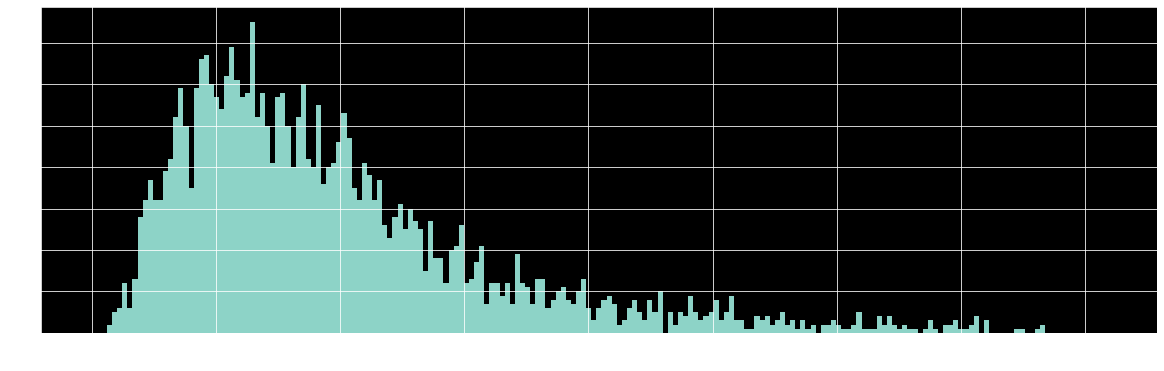

In [12]:
import matplotlib.pyplot as plt

stats = pd.DataFrame()
stats['total_words'] = seed['tokens'].apply(lambda x: len(x))

m = np.mean(stats.total_words)
print(m)

plt.subplots(figsize=(20,6))
stats['total_words'].hist(bins = np.arange(0, m*4, m/50))
plt.xlabel('Total words')
plt.ylabel('Count')

### Removing patents with not enough text (less than 30 words)

In [13]:
seed = seed[seed['tokens'].apply(lambda x: len(x) > 30)]
seed.reset_index(drop=True, inplace=True)

In [14]:
import pickle

with open(src_dir + "/data/" + seed_name + '/cleaned_text.pkl', 'wb') as outfile:
    pickle.dump(seed, outfile, protocol=pickle.HIGHEST_PROTOCOL)